In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
import scipy

from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import brainiak.utils.fmrisim

# other software used
# BrainSuite Functional Pipeline
# Group BrainSync
# NASCAR
# MIRtoolbox

%matplotlib inline

In [2]:
stimuli_root = '/hd2/research/Naturalistic/data/sans/stimuli/FeatureExtraction/'
brightness = scipy.io.loadmat(stimuli_root + 'stimuli_FNL_01_MeanGrayLevel.mat')
brightness = brightness['mean_gray_level']
print(brightness.shape)

RMS = scipy.io.loadmat(stimuli_root + 'stimuli_FNL_01_RMS.mat')
RMS = RMS['rms']
RMS = RMS.T
print(RMS.shape)

(1358, 1)
(1358, 1)


In [3]:
def normalizeData(X):
    
    import sklearn.preprocessing
    
    X_mean0 = X - np.mean(X, axis=0, keepdims=True) 
    X_normalized = sklearn.preprocessing.normalize(X_mean0, axis=0)
    
    return X_normalized

In [4]:
# load ICA components
ica_comp_path = '/hd2/research/Naturalistic/data/sans/ICA/output/CanICA_decomp.mat'

f = scipy.io.loadmat(ica_comp_path)
ica_temporal = f['temporal']
ica_spatial = f['spatial']

print(ica_temporal.shape)

(35, 1369, 30)


In [5]:
# load decomposed components

output_root = '/hd2/research/Naturalistic/code/SANS/output/'

gsync_path = output_root + 'GBS_Params_minimal.mat'
comp_path = output_root + 'NASCAR_Rank_rst0.mat'

R = 30

# load decomposed components
with h5py.File(comp_path, 'r') as f:
    test = f['result/U']
    ref = test.ref
    U = f[ref][:]
    last_comp = U[R - 1][0]
    temporal_R = np.array(f[f[last_comp][0, 0]]).T
    subject_R = np.array(f[f[last_comp][0, 2]]).T
    
    test = f['result/Lambda']
    ref = test.ref
    lambdas = f[ref][:]
    last_lambdas = lambdas[R - 1][0]
    lambda_arr = f[last_lambdas][0, :]
    
fmri_len, _ = temporal_R.shape
subj_num, _ = subject_R.shape

TR = 2

In [6]:
# load feature: brightness
brightness_norm_hrf = normalizeData(brainiak.utils.fmrisim.convolve_hrf(brightness, TR, scale_function=True, temporal_resolution=1/TR))
print(brightness_norm_hrf.shape)

# load feature: loudness
RMS_norm_hrf = normalizeData(brainiak.utils.fmrisim.convolve_hrf(RMS, TR, scale_function=True, temporal_resolution=1/TR))
print(RMS_norm_hrf.shape)

(1358, 1)
(1358, 1)


In [7]:
# transform temporal mode back to subject space
print("loading: " + gsync_path)
f = scipy.io.loadmat(gsync_path)
orth_trans = f['O']

subj_num = orth_trans.shape[2]
temporal_len = temporal_R.shape[0]

ori_subj_temporal = np.zeros((temporal_len, R, subj_num))

for i in range(subj_num):
    ori_subj_temporal[:, :, i] = np.matmul(orth_trans[:, :, i].T, temporal_R)

loading: /hd2/research/Naturalistic/code/SANS/output/GBS_Params_minimal.mat


In [8]:
time_shift = 0

# nascar visual: 15th net
avg_temporal = np.mean(ori_subj_temporal[:, 14, :], axis=1)
avg_nascar_temporal = avg_temporal.reshape([-1, 1])
print("nascar", pearsonr(avg_nascar_temporal[time_shift: len(brightness_norm_hrf)+time_shift].flatten(), brightness_norm_hrf.flatten()))
    
# ica visual: 17th net
avg_ica_temporal = np.mean(ica_temporal[:, :, 16], axis=0)
avg_ica_temporal = avg_ica_temporal.reshape([-1, 1])
print("ica", pearsonr(avg_ica_temporal[time_shift: len(brightness_norm_hrf)+time_shift].flatten(), brightness_norm_hrf.flatten()))

nascar (0.273467152466604, 1.0179104776744012e-24)
ica (0.11824134646538008, 1.2502343386524356e-05)


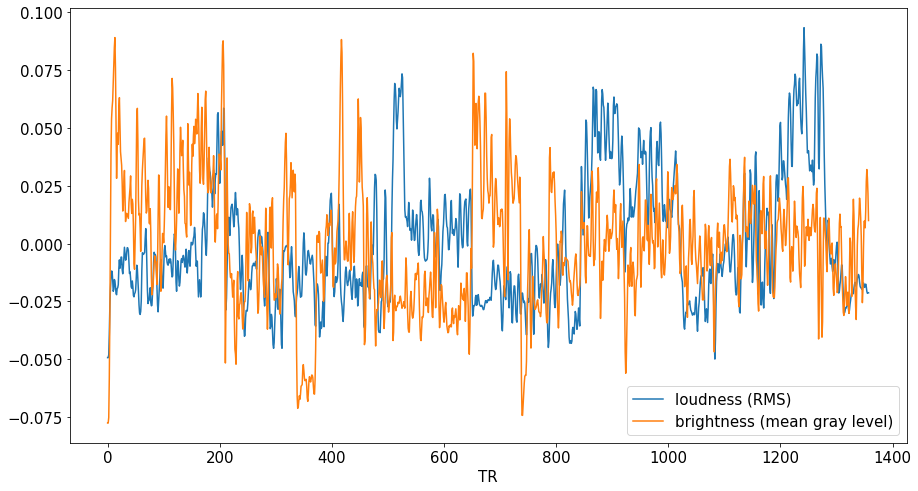

In [9]:
plt.rc('font', size=15);
f, ax = plt.subplots(figsize=(15, 8));
plt.plot(np.arange(len(RMS_norm_hrf)), RMS_norm_hrf);
plt.plot(np.arange(len(brightness_norm_hrf)), brightness_norm_hrf);
plt.legend(['loudness (RMS)', 'brightness (mean gray level)']);
plt.xlabel('TR');